In [ ]:
print("Hello, World!")
#source .venv/bin/activate


Loading CT pig data 

In [4]:
from pathlib import Path
import pydicom
import matplotlib.pyplot as plt

# Ret kun denne sti hvis nødvendigt
DICOM_DIR = Path(
    "/Users/sofiehultengren/Desktop/Kandidat speciale /CT data/Gris 1401-2025/"
    "Baseline/DICOM/00000F62/AA15D35E/AA12AD7C/Baseline CFA 1/10%"
)


In [5]:
dicom_files = sorted(DICOM_DIR.glob("*"))

print(f"Fandt {len(dicom_files)} filer")
print("Første fil:", dicom_files[0])


Fandt 1 filer
Første fil: /Users/sofiehultengren/Desktop/Kandidat speciale /CT data/Gris 1401-2025/Baseline/DICOM/00000F62/AA15D35E/AA12AD7C/Baseline CFA 1/10%/EEE2053E


TypeError: Invalid shape (160, 512, 512) for image data

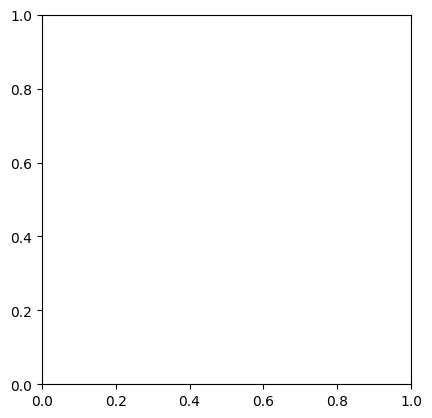

In [6]:
ds = pydicom.dcmread(dicom_files[0])

image = ds.pixel_array

plt.imshow(image, cmap="gray")
plt.title("Første DICOM slice")
plt.axis("off")
plt.show()


In [ ]:
import pydicom
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact

ds = pydicom.dcmread(dicom_files[0])
img = ds.pixel_array

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(img[0], cmap="gray", vmin=-200, vmax=800)
ax.axis("off")

def update(i):
    im.set_data(img[i])
    ax.set_title(f"Slice {i+1}/{img.shape[0]}")
    fig.canvas.draw_idle()

slider = IntSlider(min=0, max=img.shape[0]-1, step=1, value=0)
interact(update, i=slider)


In [ ]:
from pydicom import dcmread
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut
import matplotlib.pyplot as plt

ds = dcmread(dicom_files[0])           # bruger din eksisterende `dicom_files`
img = apply_modality_lut(ds.pixel_array, ds)

# Hvis der er VOI LUT (windowing) tilgængeligt:
try:
    img = apply_voi_lut(img, ds)
except Exception:
    pass

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()